# Baseline model training

In [1]:
# обучение
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from efficientnet_pytorch import EfficientNet
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# utils
import os
from tqdm.notebook import tqdm

In [2]:
# проверяем доступность видеодрайвера

print("Is CUDA available: ", torch.cuda.is_available())
print("CUDA version: ", torch.version.cuda)

Is CUDA available:  True
CUDA version:  11.7


In [6]:
# разделим данные на трейн и тест
import shutil
from sklearn.model_selection import train_test_split

# Директория с балансированными данными
balanced_directory = '../dataset/augmented_dataset/'

# Директории для тренировочных и тестовых данных
train_directory = os.path.join('dataset/', 'train')
test_directory = os.path.join('dataset/', 'test')

# Создаем директории, если они не существуют
os.makedirs(train_directory, exist_ok=True)
os.makedirs(test_directory, exist_ok=True)



In [7]:
# Разделение данных и сохранение в соответствующие папки
for class_name in ['no', 'r', 'yes']:
    # Получаем список файлов для текущего класса
    files = [f for f in os.listdir(balanced_directory) if f.startswith(class_name)]
    
    # Разделяем файлы на тренировочные и тестовые
    train_files, test_files = train_test_split(files, test_size=0.2, random_state=42)
    
    # Функция для копирования файлов в соответствующую директорию
    def copy_files(files, directory):
        class_dir = os.path.join(directory, class_name)
        os.makedirs(class_dir, exist_ok=True)
        for f in files:
            shutil.copy2(os.path.join(balanced_directory, f), os.path.join(class_dir, f))
    
    # Копируем файлы в тренировочную и тестовую директории
    copy_files(train_files, train_directory)
    copy_files(test_files, test_directory)

print("Данные разделены на тренировочные и тестовые наборы.")


Данные разделены на тренировочные и тестовые наборы.


In [3]:
# фиксируем гиперпараметры предстоящего эксперимента

batch_size = 64
learning_rate = 0.001
num_epochs = 10

# будет также использоваться позднее при сохранении модели и чекпоинтов, обязательно менять перед началом нового эксперимента!
experiment_name = f'EffNetB7_batchsize_{batch_size}_lr_{learning_rate}_epochs_{num_epochs}' 

# создаем папку, куда будем сохранять чекпоинты, веса и метрики
exp_dir_path = f"experiments/{experiment_name}"
os.makedirs(exp_dir_path, exist_ok=True)

In [4]:
class ImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = os.listdir(root_dir)
        self.files = []
        for class_name in self.classes:
            class_dir = os.path.join(root_dir, class_name)
            self.files += [(os.path.join(class_dir, f), class_name) for f in os.listdir(class_dir)]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path, class_name = self.files[idx]
        image = Image.open(img_path).convert('L')
        if self.transform:
            image = self.transform(image)
        return image, self.classes.index(class_name)

In [18]:
transform = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # normalize to [-1, 1] for each channel
])


In [19]:
train_data = ImageDataset('dataset/train/', transform=transform)
test_data = ImageDataset('dataset/test/', transform=transform)

In [20]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=8)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=8)

In [10]:
model = EfficientNet.from_pretrained('efficientnet-b7')
num_ftrs = model._fc.in_features
model._fc = nn.Linear(num_ftrs, len(train_data.classes))

Loaded pretrained weights for efficientnet-b7


In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("loading model to device")
model = model.to(device)
print("model loaded")


if torch.cuda.is_available():
    print(f'Using {torch.cuda.get_device_name(0)}')
else:
    print('Using CPU')

    
# переводим модель в training mode
model.train()  

# устанавливаем seed для воспроизводимости
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
    
    
# определяем критерии остановки обучения если необходимо
patience = 5   # количество эпох без улучшения до остановки обучения 
best_loss = float('inf')
epochs_no_improve = 0



for epoch in range(num_epochs):
    running_loss = 0.0
    all_labels = []
    all_predictions = []
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), leave=False)
    
    for i, (images, labels) in progress_bar:  
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()  

        outputs = model(images)  # forward pass
        loss = criterion(outputs, labels)  # compute the loss
        loss.backward()  # backward pass
        optimizer.step()  # update the weights

        # сохраняем лейблы и предикшены для расчета метрик
        _, predictions = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predictions.cpu().numpy())

        running_loss += loss.item() * images.size(0)
        progress_bar.set_description(f"Epoch {epoch+1} Loss: {running_loss/(i+1):.2f}")

    # рассчитываем метрики
    precision = precision_score(all_labels, all_predictions, average=None)
    recall = recall_score(all_labels, all_predictions, average=None)
    f1 = f1_score(all_labels, all_predictions, average=None)
    avg_precision = precision_score(all_labels, all_predictions, average='macro')
    avg_recall = recall_score(all_labels, all_predictions, average='macro')
    avg_f1 = f1_score(all_labels, all_predictions, average='macro')
    accuracy = accuracy_score(all_labels, all_predictions)

    epoch_loss = running_loss / len(train_data)
    
    print(f"\nEpoch {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.4f}, Precision: {avg_precision:.4f}, \
Recall: {avg_recall:.4f}, F1 Score: {avg_f1:.4f}")
    
    scheduler.step(epoch_loss)  # step the learning rate scheduler
    

    # проверка предварительной остановки обучения
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        epochs_no_improve = 0
        best_epoch = epoch+1
        model_saving_name = f"{exp_dir_path}/{experiment_name}_best.pth"
        
        # сохраняем лучшую модель
        torch.save(model.state_dict(), model_saving_name)
        
        
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print('Оставливаем обучение, модель перестала обучаться')
            break
    
    
    # сохраняем последний чекпоинт на случай прерывания обучения
    torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict' : scheduler.state_dict(),
    'loss': loss,
    }, f"{exp_dir_path}/{experiment_name}_checkpoint.pth")
    
    
    
    # Переключение модели в режим оценки
    model.eval()

    all_test_labels = []
    all_test_predictions = []
    running_loss = 0.0

    # Итерация по тестовому набору данных
    progress_bar = tqdm(enumerate(test_loader), total=len(test_loader), leave=False)
    for i, (images, labels) in progress_bar:
        images = images.to(device)
        labels = labels.to(device)

        # Предсказания модели
        with torch.no_grad():
            outputs = model(images)

        # Вычисление потерь
        loss = criterion(outputs, labels)
        running_loss += loss.item() * images.size(0)

        # Сохранение меток и предсказаний
        _, predictions = torch.max(outputs, 1)
        all_test_labels.extend(labels.cpu().numpy())
        all_test_predictions.extend(predictions.cpu().numpy())

    # Вычисление финальных метрик
    test_loss = running_loss / len(test_data)
    test_precision = precision_score(all_test_labels, all_test_predictions, average='macro')
    test_recall = recall_score(all_test_labels, all_test_predictions, average='macro')
    test_f1 = f1_score(all_test_labels, all_test_predictions, average='macro')
    test_accuracy = accuracy_score(all_test_labels, all_test_predictions)

    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test Precision: {test_precision:.4f}, \
Test Recall: {test_recall:.4f}, Test F1 Score: {test_f1:.4f}")

    # метрик по классам
    test_precision_class = precision_score(all_test_labels, all_test_predictions, average=None)
    test_recall_class = recall_score(all_test_labels, all_test_predictions, average=None)
    test_f1_class = f1_score(all_test_labels, all_test_predictions, average=None)

    model.train() # переводим модель обратно в training mode

loading model to device
model loaded
Using NVIDIA GeForce RTX 3070 Laptop GPU


  0%|          | 0/19 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7ffc149000><function _MultiProcessingDataLoaderIter.__del__ at 0x7f7ffc149000><function _MultiProcessingDataLoaderIter.__del__ at 0x7f7ffc149000>


Traceback (most recent call last):
Traceback (most recent call last):
  File "/mnt/c/Users/edavletshin/courses/PISH DDE/PCR_product_detection/venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
  File "/mnt/c/Users/edavletshin/courses/PISH DDE/PCR_product_detection/venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Traceback (most recent call last):
  File "/mnt/c/Users/edavletshin/courses/PISH DDE/PCR_product_detection/venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()        self._shutdown_workers()self._shutdown_workers()

  File "/mnt/c/Users/edavletshin/courses/PISH DDE/PCR_pr


Epoch 1, Loss: 0.5190, Accuracy: 0.7833, Precision: 0.7858, Recall: 0.7833, F1 Score: 0.7835


  0%|          | 0/5 [00:00<?, ?it/s]

Test Loss: 23.4254, Test Accuracy: 0.3333, Test Precision: 0.1111, Test Recall: 0.3333, Test F1 Score: 0.1667


/mnt/c/Users/edavletshin/courses/PISH DDE/PCR_product_detection/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/edavletshin/courses/PISH DDE/PCR_product_detection/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/19 [00:00<?, ?it/s]


Epoch 2, Loss: 0.1299, Accuracy: 0.9658, Precision: 0.9661, Recall: 0.9658, F1 Score: 0.9658


  0%|          | 0/5 [00:00<?, ?it/s]

Test Loss: 7.8583, Test Accuracy: 0.3333, Test Precision: 0.1111, Test Recall: 0.3333, Test F1 Score: 0.1667


/mnt/c/Users/edavletshin/courses/PISH DDE/PCR_product_detection/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/edavletshin/courses/PISH DDE/PCR_product_detection/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/19 [00:00<?, ?it/s]


Epoch 3, Loss: 0.1487, Accuracy: 0.9550, Precision: 0.9550, Recall: 0.9550, F1 Score: 0.9549


  0%|          | 0/5 [00:00<?, ?it/s]

Test Loss: 2.2454, Test Accuracy: 0.4933, Test Precision: 0.7989, Test Recall: 0.4933, Test F1 Score: 0.4457


  0%|          | 0/19 [00:00<?, ?it/s]


Epoch 4, Loss: 0.0521, Accuracy: 0.9875, Precision: 0.9875, Recall: 0.9875, F1 Score: 0.9875


  0%|          | 0/5 [00:00<?, ?it/s]

Test Loss: 0.3913, Test Accuracy: 0.8767, Test Precision: 0.9100, Test Recall: 0.8767, Test F1 Score: 0.8759


  0%|          | 0/19 [00:00<?, ?it/s]


Epoch 5, Loss: 0.0219, Accuracy: 0.9950, Precision: 0.9950, Recall: 0.9950, F1 Score: 0.9950


  0%|          | 0/5 [00:00<?, ?it/s]

Test Loss: 0.2135, Test Accuracy: 0.9367, Test Precision: 0.9468, Test Recall: 0.9367, Test F1 Score: 0.9376


  0%|          | 0/19 [00:00<?, ?it/s]


Epoch 6, Loss: 0.0459, Accuracy: 0.9883, Precision: 0.9883, Recall: 0.9883, F1 Score: 0.9883


  0%|          | 0/5 [00:00<?, ?it/s]

Test Loss: 0.1166, Test Accuracy: 0.9733, Test Precision: 0.9742, Test Recall: 0.9733, Test F1 Score: 0.9734


  0%|          | 0/19 [00:00<?, ?it/s]


Epoch 7, Loss: 0.0352, Accuracy: 0.9917, Precision: 0.9918, Recall: 0.9917, F1 Score: 0.9917


  0%|          | 0/5 [00:00<?, ?it/s]

Test Loss: 0.1441, Test Accuracy: 0.9733, Test Precision: 0.9753, Test Recall: 0.9733, Test F1 Score: 0.9736


  0%|          | 0/19 [00:00<?, ?it/s]


Epoch 8, Loss: 0.0417, Accuracy: 0.9883, Precision: 0.9883, Recall: 0.9883, F1 Score: 0.9883


  0%|          | 0/5 [00:00<?, ?it/s]

Test Loss: 0.1427, Test Accuracy: 0.9800, Test Precision: 0.9807, Test Recall: 0.9800, Test F1 Score: 0.9800


  0%|          | 0/19 [00:00<?, ?it/s]


Epoch 9, Loss: 0.0210, Accuracy: 0.9950, Precision: 0.9950, Recall: 0.9950, F1 Score: 0.9950


  0%|          | 0/5 [00:00<?, ?it/s]

Test Loss: 0.0521, Test Accuracy: 0.9933, Test Precision: 0.9935, Test Recall: 0.9933, Test F1 Score: 0.9933


  0%|          | 0/19 [00:00<?, ?it/s]


Epoch 10, Loss: 0.0088, Accuracy: 0.9967, Precision: 0.9967, Recall: 0.9967, F1 Score: 0.9967


  0%|          | 0/5 [00:00<?, ?it/s]

Test Loss: 0.0443, Test Accuracy: 0.9900, Test Precision: 0.9901, Test Recall: 0.9900, Test F1 Score: 0.9900


In [22]:
# Загрузка лучшей сохраненной модели
model_path = model_saving_name
model.load_state_dict(torch.load(model_path))

# Переключение модели в режим оценки
model.eval()

all_labels = []
all_predictions = []
running_loss = 0.0

# Итерация по тестовому набору данных
progress_bar = tqdm(enumerate(test_loader), total=len(test_loader), leave=False)
for i, (images, labels) in progress_bar:
    images = images.to(device)
    labels = labels.to(device)

    # Предсказания модели
    with torch.no_grad():
        outputs = model(images)

    # Вычисление потерь
    loss = criterion(outputs, labels)
    running_loss += loss.item() * images.size(0)

    # Сохранение меток и предсказаний
    _, predictions = torch.max(outputs, 1)
    all_labels.extend(labels.cpu().numpy())
    all_predictions.extend(predictions.cpu().numpy())

# Вычисление финальных метрик
test_loss = running_loss / len(test_data)
test_precision = precision_score(all_labels, all_predictions, average='macro')
test_recall = recall_score(all_labels, all_predictions, average='macro')
test_f1 = f1_score(all_labels, all_predictions, average='macro')
test_accuracy = accuracy_score(all_labels, all_predictions)

print(f"Test Loss: {test_loss:.2f}, Test Accuracy: {test_accuracy:.2f}, Test Precision: {test_precision}, \
Test Recall: {test_recall}, Test F1 Score: {test_f1}")


  0%|          | 0/5 [00:00<?, ?it/s]

Test Loss: 0.04, Test Accuracy: 0.99, Test Precision: 0.9900970489205784, Test Recall: 0.9899999999999999, Test F1 Score: 0.9899995024628091


In [24]:
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

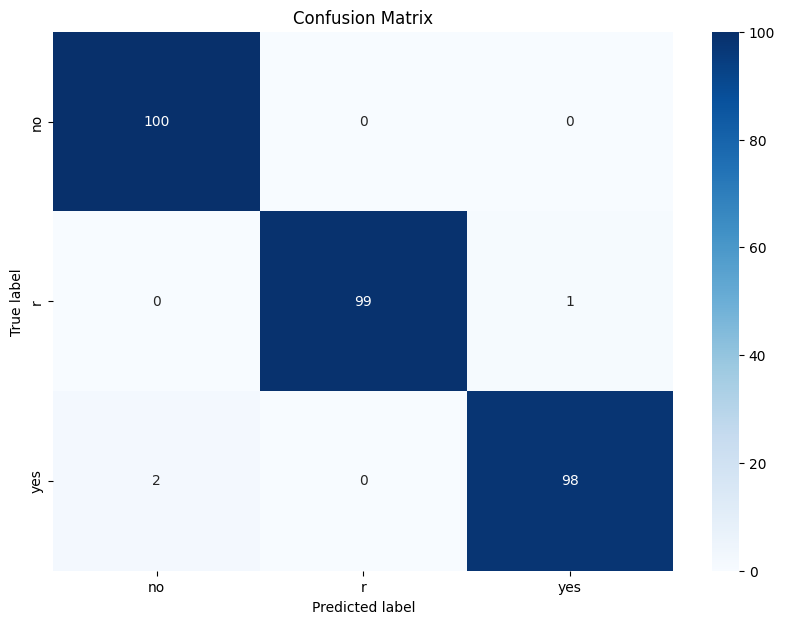

In [25]:
# Compute the confusion matrix
cm = confusion_matrix(all_test_labels, all_test_predictions)

# Transform it to a DataFrame for easier plotting
cm_df = pd.DataFrame(cm, index=train_data.classes, columns=train_data.classes)

plt.figure(figsize=(10, 7))

# Plot the matrix as a heatmap
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='d')

plt.title("Confusion Matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig(f'{exp_dir_path}/{experiment_name}_confusion_matrix.png')
plt.show()

In [27]:
del model
torch.cuda.empty_cache()  # очищаем GPU